In [38]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

[[ 9.9604767 ]
 [10.33941023]
 [-9.90354876]
 [ 5.38516481]
 [-1.        ]
 [ 2.        ]
 [ 5.49125178]]


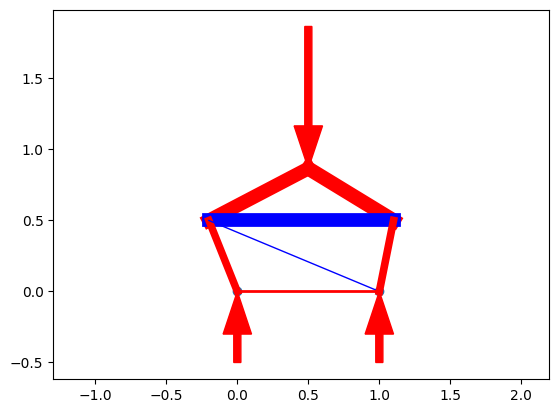

In [95]:
class Truss:
    def __init__(self, nodes : np.ndarray, edges :  np.ndarray) -> None:
        """Nodes: Nx2 np array of X,Y coord pairs.
        Edges: Mx2 array of (i,j) edge pairs"""
        self.n_nodes = len(nodes)
        self.n_edges = len(edges)
        assert nodes.shape == (self.n_nodes, 2)
        assert edges.shape == (self.n_edges, 2)

        self.nodes = nodes
        self.edges = edges
        self.loads = []
        self.forces = None
        self._validate_edges()
    
    def _validate_edges(self):
        """Validates that all edges make sense and have no duplicates"""
        edge_set = set()
        for i, j in self.edges:
            assert 0 <= i < self.n_nodes, f"index error: {i}"
            assert 0 <= j < self.n_nodes, f"index error for {j}"
            edge = frozenset((i, j))
            assert edge not in edge_set, f"Duplicate edge {(i,j)}!"
            edge_set.add(edge)
    
    def add_load(self, idx, fx, fy):
        """"""
        assert 0 <= idx < self.n_nodes
        self.loads.append((idx, fx, fy))
    
    def draw(self) -> None:
        plt.axis('equal')

        # draw nodes
        plt.scatter(self.nodes[:, 0], self.nodes[:, 1])
        
        # draw edges
        if self.forces is None:
            for i, j in self.edges:
                plt.plot(nodes[[i, j], 0], nodes[[i, j], 1] , 'k-')
        else:
            for (i, j), f in zip(self.edges, self.forces):
                color = 'r' if f > 0 else 'b'
                plt.plot(
                    nodes[[i, j], 0], nodes[[i, j], 1], 
                    f'{color}-',
                    linewidth=abs(f))

        # draw loads
        for idx, fx, fy in self.loads:
            fx /= 10
            fy /= 10
            plt.arrow(self.nodes[idx][0] - fx, self.nodes[idx][1] - fy, fx, fy, 
                head_width = 0.2,
                width = 0.05,
                # ec ='red',
                color='red',
                length_includes_head=True)
            
    def _get_unit_xy(self, dx, dy):
        """Return the unit components of x, y normalized by total vector length"""
        hypot = np.sqrt(dx**2 + dy**2)
        return dx / hypot, dy / hypot

    
    def calculate_forces(self):
        """Computes the force on each beam!
        A@F = L
        Positive forces are compression, negative are tension.
        """

        # create design matrix
        A = np.zeros((2 * self.n_nodes, self.n_edges))
        for edge_i, (n1_i, n2_i) in enumerate(self.edges):
            # print("----------")
            # print(f"{edge_i=}, {n1_i=}, {n2_i=}")

            n1x, n1y = self.nodes[n1_i]
            n2x, n2y = self.nodes[n2_i]
            # print(f" n1, n2: ({n1x, n1y}), ({n2x, n2y})")
            ux, uy = self._get_unit_xy(n1x - n2x, n1y - n2y)
            # print(f"{ux=}, {uy=}")

            # towards N1
            A[n1_i * 2][edge_i], A[n1_i * 2 + 1][edge_i] = ux, uy

            # towards N2
            A[n2_i * 2][edge_i], A[n2_i * 2 + 1][edge_i] = -ux, -uy


        # construct load vector
        load_vec = np.zeros((2 * self.n_nodes, 1))  # stored as [x1,y1,x2,y2...]
        for idx, fx, fy in self.loads:
            load_vec[idx * 2] += fx
            load_vec[idx * 2 + 1] += fy

        self.forces = np.linalg.lstsq(A, -load_vec, rcond=None)[0]
        return self.forces


# equilateral triangle example
nodes = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (-.2, .5),
    (1.1, .5),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (0, 2), (1, 2), (1, 3), (1,4), (4,3), (2,4)))
t = Truss(nodes, edges)

t.add_load(0, 0, -10)
t.add_load(3, 0, 5)
t.add_load(4, 0, 5)

print(t.calculate_forces())
t.draw()


In [ ]:
"""
how to construct the force matrix A for nodes:

"""
